## Setup

We'll be using a modified version of the Frozen Lake environment to study value iteration, policy iteration, and temporal difference policy iteration.  This notebook is adapted from Homework 2 of UC Berkeley's Spring 2017 Deep Reinforcement Learning course [http://rll.berkeley.edu/deeprlcourse/].  

Here is the description of the original Frozen Lake environment: 

In [1]:
from frozen_lake import FrozenLakeEnv
env = FrozenLakeEnv()
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located

    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.

    


Ours is exactly the same, except we add rewards of -0.001 to each transition (otherwise policy iteration is going to behave weirdly).  Oh, and we'll be maximizing reward rather than minimizing cost - all the math is the same except mins are replaced with max.  

In [2]:
# Some basic imports and setup
%matplotlib inline
import numpy as np, numpy.random as nr, gym
import matplotlib.pyplot as plt
from MDP import MDP

In [3]:
ALPHA=1   #Discount factor
nIt = 50  #Number of iterations to run each algorithm
transient = [0,1,2,3,4,6,8,9,10,13,14] #Transient (non-terminal) states

In [4]:
#Represent environment as MDP object
mdp = MDP( {s : {a : [list(tup[:3]) for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, transient, env.desc)

And we modify the MDP to add transition costs, and save our modified MDP for future use:

In [5]:
for s in mdp.P.keys(): 
    if s in transient:
        for a in mdp.P[s].keys(): 
            for t in mdp.P[s][a]:
                if t[1] in mdp.transient: 
                    t[2] = -0.001

In [6]:
import dill
with open('FrozenLakeMDP.pkl', 'wb') as output:
  dill.dump(mdp, output)

## Value Iteration

First we'll look at value iteration.  It will help to define a function $\texttt{compute_Qmu}$, which returns the *Q function* corresponding to a given cost-to-go vector $\texttt{J_mu}$.  The Q-function gives the expected total cost for a given (state, action) pair, so $\texttt{compute_Qmu}$ returns a 16x4 array whose entries are long-run costs. 

We can then implement value iteration by initializing a cost vector, then (1) computing the corresponding Q function and (2) setting the new cost vector equal to the max over actions of this Q function, until convergence.  

The plot shows the convergence of the costs at each state.

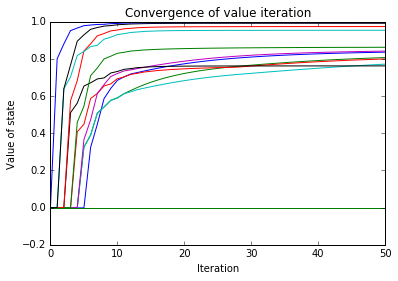

In [7]:
def compute_Qmu(alpha, J_mu, mdp):
    '''
    Returns Qmu, an mdp.nS x mdp.nA array representing the Q function at
    cost vector J 
    '''
    Qmu = np.array([[sum([l[0]*(l[2] + alpha*J_mu[l[1]]) for l in mdp.P[s][a]]) for a in range(mdp.nA)] for s in range(mdp.nS)])    
    return Qmu

def value_iteration(alpha, mdp, nIt):
    J_k = np.zeros(mdp.nS)   #Initialize cost
    Js = [J_k]               #Lists to collect iterates
    mus = []
    for it in range(nIt):
        Qmu = compute_Qmu(alpha, J_k, mdp)
        J_k, mu_k =  np.max(Qmu,axis=1), np.argmax(Qmu, axis=1)
        Js.append(J_k)
        mus.append(mu_k)
    return np.array(Js), np.array(mus)
Js_VI, mus_VI = value_iteration(ALPHA, mdp, 50)

#Plot
plt.title('Convergence of value iteration')
plt.xlabel('Iteration')
plt.ylabel('Value of state')
plt.plot(Js_VI)
plt.show()

We can also see the convergence of the policies: 

In [8]:
def plot_policy(env, Js, mus, nIt=7):
    for (J, mu) in zip(Js[:nIt], mus[:nIt]):
        plt.figure(figsize=(3,3))
        plt.imshow(J.reshape(4,4), cmap='gray', interpolation='none', clim=(0,1))
        ax = plt.gca()
        ax.set_xticks(np.arange(4)-.5)
        ax.set_yticks(np.arange(4)-.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        Y, X = np.mgrid[0:4, 0:4]
        a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(-1, 0)}
        Mu = mu.reshape(4,4)
        for y in range(4):
            for x in range(4):
                a = Mu[y, x]
                u, v = a2uv[a]
                plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1) 
                plt.text(x, y, str(env.desc[y,x].item().decode()),
                         color='g', size=12,  verticalalignment='center',
                         horizontalalignment='center', fontweight='bold')
        plt.grid(color='b', lw=2, ls='-')

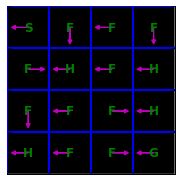

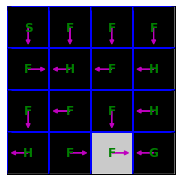

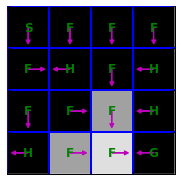

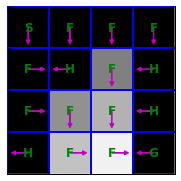

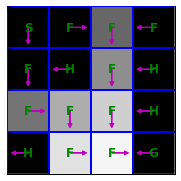

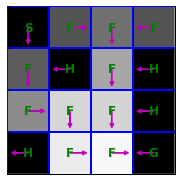

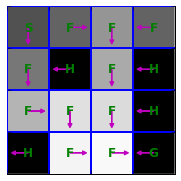

In [9]:
plot_policy(env, Js_VI, mus_VI)

## Policy Iteration

Next we'll look at policy iteration.  We need to define $\texttt{compute_Jmu}$, which solves the Bellman equations and returns the resulting cost vector.  This function takes the list of transient states as an argument, since we only solve the system of equations for the non-terminal states.  

In [10]:
def compute_Jmu(alpha, mdp, mu, transient):
    '''
    Solve system (I-alpha*P_mu)J = g_mu, 
    where J is cost under mu, P_mu is transition matrix, and g_mu is cost per stage
    '''
    #Get one-stage costs and transition matrix under policy mu
    g_mu = np.array([sum([l[0]*l[2] for l in mdp.P[s][mu[s]]]) for s in transient])
    P_mu = np.zeros((mdp.nS, mdp.nS))
    for s in range(mdp.nS):
        for l in mdp.P[s][mu[s]]:
            P_mu[s,l[1]] += l[0]            
    P_mu = P_mu[transient,:]    
    P_mu = P_mu[:,transient]
    
    #Solve Bellman equation at transient states
    J = np.zeros(mdp.nS)
    J[transient] = np.linalg.solve(np.identity(mdp.nS-5)-alpha*P_mu, g_mu)    
    return J

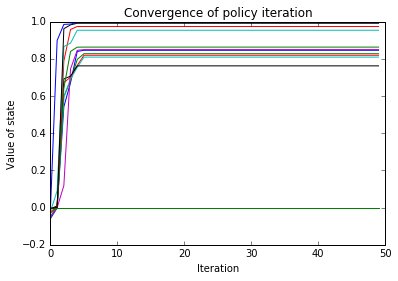

In [11]:
def policy_iteration(alpha, mdp, nIt, transient):
    mu_k = np.zeros(mdp.nS,dtype='int') #Initialize policy
    mus = [mu_k]   #Lists to collect iterates
    Js = []
    for it in range(nIt):   
        J_mu = compute_Jmu(alpha, mdp, mu_k, transient)  #Value step
        Q_mu = compute_Qmu(alpha, J_mu, mdp)             #Policy step
        mu_kp1 = Q_mu.argmax(axis=1)
        Js.append(J_mu)
        mus.append(mu_kp1)
        mu_k = mu_kp1
    return Js, mus
Js_PI, mus_PI = policy_iteration(ALPHA, mdp, nIt, transient)

#Plot
plt.title('Convergence of policy iteration')
plt.xlabel('Iteration')
plt.ylabel('Value of state')
plt.plot(Js_PI)
plt.show()

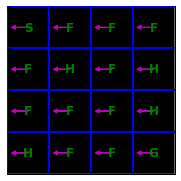

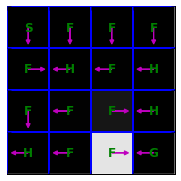

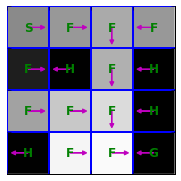

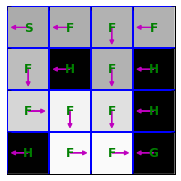

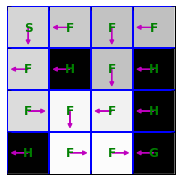

In [12]:
plot_policy(env, Js_PI, mus_PI, nIt=5)